# Statistical hypothesis testing

URL https://github.com/FIIT-IAU/

**We want to verify whether the number of engine cylinders has an effect on consumption.**

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing

from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import numpy as np

from statsmodels.formula.api import ols


In [36]:
cars = pd.read_csv('data/auto-mpg.data', 
                   delim_whitespace=True, 
                   names = ['mpg', 'cylinders', 'displacement','horsepower',
                            'weight', 'acceleration', 'model_year', 'origin', 'name'],
                   na_values='?')
cars.head()

/var/folders/j_/bs2_06f5405cy265hh1ttq540000gn/T/ipykernel_50080/2311559318.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cars = pd.read_csv('data/auto-mpg.data',


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Homework

a. Check if the difference in fuel consumption between 4-cylinder and 6-cylinder engines is statistically significant.

b. Check if the difference in fuel consumption between 4-cylinder and 5-cylinder engines is statistically significant.

c. An even better approach is to use a statistical test that allows for the comparison of multiple groups at once. The generalization of the t-test for multiple groups is called **ANOVA (Analysis of Variance)**.

Invisible note
<!--
Care should be taken with repeated pair testing. With each additional test, the probability of the 1st order increases. In that case, a correction for retesting should be used, e.g. *Bonferroni correction*, when the $p$-value is compared against the $\alpha / m$ value, where $\alpha$ is the permissible value of the probability of the 1st order error and $m$ is the number of tested hypotheses (pairwise tests).
//-->

### Typy stlpcov

In [37]:
cars.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
name             object
dtype: object

In [38]:
cars.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [39]:
# dropni riadky s NA
cars = cars.dropna(subset=['mpg','cylinders','horsepower','displacement','weight','acceleration'])
cars.shape, cars.isna().sum()

((392, 9),
 mpg             0
 cylinders       0
 displacement    0
 horsepower      0
 weight          0
 acceleration    0
 model_year      0
 origin          0
 name            0
 dtype: int64)

In [40]:
sns.set(style="whitegrid", context="notebook")

numeric = ['mpg','displacement','horsepower','weight','acceleration']
cars[numeric].describe()

,mpg,displacement,horsepower,weight,acceleration
count,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,194.411990,104.469388,2977.584184,15.541327
std,7.805007,104.644004,38.491160,849.402560,2.758864
min,9.000000,68.000000,46.000000,1613.000000,8.000000
25%,17.000000,105.000000,75.000000,2225.250000,13.775000
50%,22.750000,151.000000,93.500000,2803.500000,15.500000
75%,29.000000,275.750000,126.000000,3614.750000,17.025000
max,46.600000,455.000000,230.000000,5140.000000,24.800000


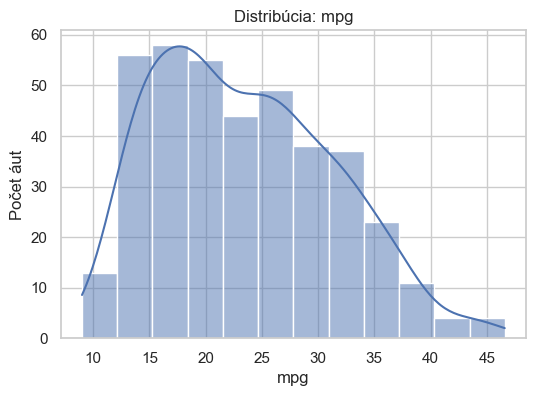

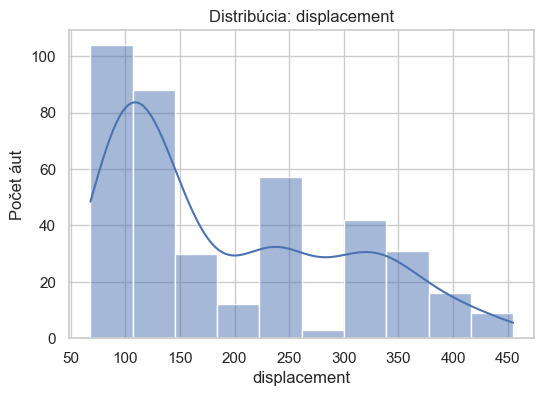

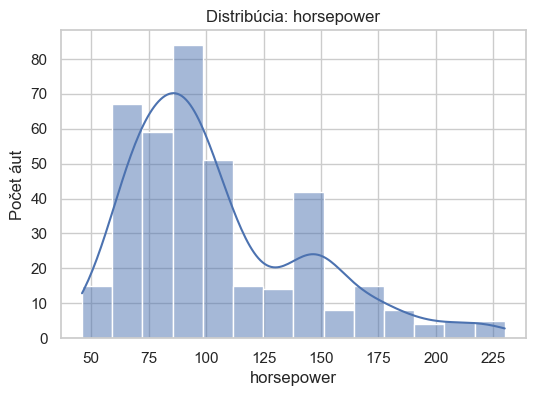

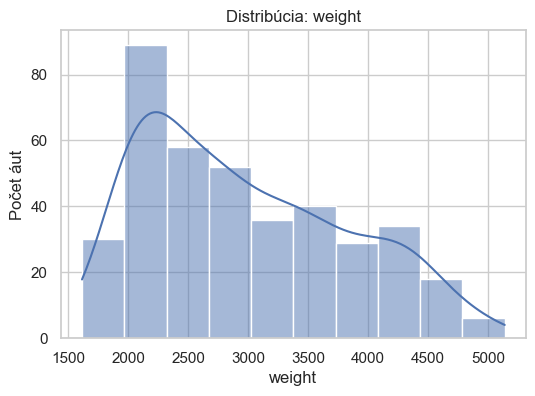

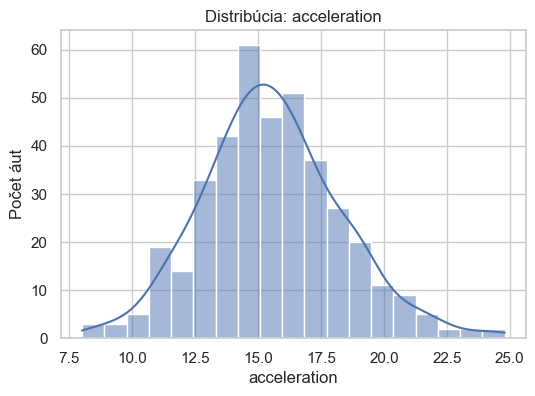

In [41]:
# histogramy + KDE
for col in numeric:
    plt.figure(figsize=(6,4))
    sns.histplot(cars[col], kde=True)
    plt.title(f'Distribúcia: {col}')
    plt.xlabel(col)
    plt.ylabel('Počet áut')
    plt.show()


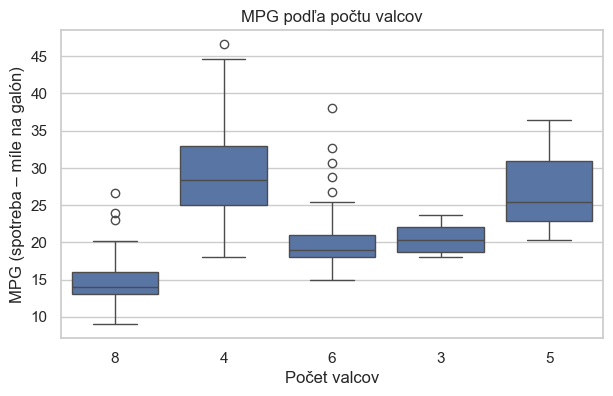

In [42]:
# boxplot mpg podľa počtu valcov
plt.figure(figsize=(7,4))
sns.boxplot(x=cars['cylinders'].astype(str), y='mpg', data=cars)
plt.xlabel('Počet valcov')
plt.ylabel('MPG (spotreba – míle na galón)')
plt.title('MPG podľa počtu valcov')
plt.show()

- H₀ (ANOVA): Priemerné mpg je rovnaké pre všetky skupiny valcov (4, 6, 8).
- H₁: Aspoň jedna skupina sa líši.


#### 1. Normalita v skupinách (len orientačne; pri väčších n stačí robustný prístup):


In [43]:
for c in sorted(cars['cylinders'].dropna().unique()):
    x = cars.loc[cars['cylinders']==c, 'mpg'].dropna()
    if len(x) >= 3 and len(x) <= 5000:  # Shapiro limit
        stat, p = shapiro(x)
        print(f'cyl={c}: Shapiro p={p:.4f}, n={len(x)}')

cyl=3: Shapiro p=0.7267, n=4
cyl=4: Shapiro p=0.0023, n=199
cyl=5: Shapiro p=0.6018, n=3
cyl=6: Shapiro p=0.0000, n=83
cyl=8: Shapiro p=0.0000, n=103


#### 2. Homogenita variancií (Levene):

In [44]:
groups = [cars.loc[cars['cylinders']==c, 'mpg'].dropna() for c in sorted(cars['cylinders'].dropna().unique())]
stat, p = levene(*groups, center='median')  # median je robustnejší
print(f'Levene p={p:.4f}')

Levene p=0.0000


- Ak normalita ~OK a variancie ~rovnaké → klasická jednofaktorová ANOVA.
- Ak variancie nerovnaké → Welch ANOVA (robustnejšia).
- Ak silná neniormalita / outliery → Kruskal–Wallis (neparametrická).

## Otestovanie ANOVA


#### Varianta A: Klasická ANOVA

In [45]:
model = ols('mpg ~ C(cylinders)', data=cars).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(cylinders),15274.506767,4.0,172.954629,8.785541e-85
Residual,8544.486702,387.0,NaN,NaN


#### Varianta B: Welch ANOVA

In [46]:
model = ols('mpg ~ C(cylinders)', data=cars).fit()

# Welch ANOVA = ANOVA s robustnou korekciou (HC3)
welch_anova = sm.stats.anova_lm(model, typ=2, robust="hc3")
welch_anova

,sum_sq,df,F,PR(>F)
C(cylinders),18822.812399,4.0,213.132417,2.014843e-96
Residual,8544.486702,387.0,NaN,NaN


In [47]:
stat, p = kruskal(*groups)
print(f'Kruskal–Wallis p={p:.6f}')

Kruskal–Wallis p=0.000000


## Post-hoc testy

### Parametrické post-hoc testy - Tukey HSD

In [48]:
import statsmodels.stats.multicomp as mc

posthoc = mc.pairwise_tukeyhsd(endog=cars['mpg'], groups=cars['cylinders'].astype(str), alpha=0.05)
print(posthoc)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     3      4   8.7339 0.0025   2.2306  15.2373   True
     3      5   6.8167 0.3193   -3.019  16.6524  False
     3      6  -0.5765 0.9993  -7.1688   6.0158  False
     3      8  -5.5869 0.1367 -12.1497   0.9759  False
     4      5  -1.9173 0.9561  -9.4082   5.5737  False
     4      6  -9.3104    0.0 -10.9931  -7.6277   True
     4      8 -14.3208    0.0  -15.884 -12.7576   True
     5      6  -7.3932 0.0592 -14.9614   0.1751  False
     5      8 -12.4036 0.0001 -19.9461   -4.861   True
     6      8  -5.0104    0.0  -6.9099  -3.1109   True
------------------------------------------------------


### Dunnov test (neparametrický post-hoc test)

In [49]:
from itertools import combinations
from scipy.stats import mannwhitneyu
import math

levels = sorted(cars['cylinders'].dropna().unique())
pairs = list(combinations(levels, 2))
pvals = []

for a,b in pairs:
    x = cars.loc[cars['cylinders']==a, 'mpg']
    y = cars.loc[cars['cylinders']==b, 'mpg']
    stat, p = mannwhitneyu(x, y, alternative='two-sided')
    pvals.append((f'{a} vs {b}', p))

# Holm-Bonferroni korekcia
m = len(pvals)
pvals_sorted = sorted(pvals, key=lambda t: t[1])
adjusted = []
for i, (name, p) in enumerate(pvals_sorted, start=1):
    padj = min(1.0, p * (m - i + 1))
    adjusted.append((name, p, padj))

adjusted


[('4 vs 8',
  np.float64(1.021298637352505e-44),
  np.float64(1.021298637352505e-43)),
 ('4 vs 6',
  np.float64(6.565719769148787e-30),
  np.float64(5.909147792233909e-29)),
 ('6 vs 8',
  np.float64(1.6404405687277573e-20),
  np.float64(1.3123524549822059e-19)),
 ('3 vs 4',
  np.float64(0.0023291434880892328),
  np.float64(0.016304004416624628)),
 ('3 vs 8',
  np.float64(0.003151207253496008),
  np.float64(0.018907243520976048)),
 ('5 vs 8',
  np.float64(0.003990163326658403),
  np.float64(0.019950816633292016)),
 ('5 vs 6', np.float64(0.03678012270445737), np.float64(0.1471204908178295)),
 ('3 vs 5', np.float64(0.22857142857142856), np.float64(0.6857142857142857)),
 ('3 vs 6', np.float64(0.47051588854598625), np.float64(0.9410317770919725)),
 ('4 vs 5', np.float64(0.5569374032540746), np.float64(0.5569374032540746))]

#### Cohenovo d pre veľkosť efektu medzi dvoma skupinami

In [50]:
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    va, vb = a.var(ddof=1), b.var(ddof=1)
    # pooled SD
    s = np.sqrt(((na-1)*va + (nb-1)*vb) / (na+nb-2))
    return (a.mean() - b.mean()) / s

x4 = cars.loc[cars['cylinders']==4, 'mpg']
x6 = cars.loc[cars['cylinders']==6, 'mpg']
d_46 = cohens_d(x4, x6)
d_46

np.float64(1.7907491037559238)

#### Cliffovo delta pre veľkosť efektu medzi dvoma skupinami

In [51]:
def cliffs_delta(a, b):
    # P(X>Y) - P(X<Y)
    a = np.asarray(a); b = np.asarray(b)
    count = 0
    for ai in a:
        count += np.sum(ai > b) - np.sum(ai < b)
    return count / (len(a)*len(b))

delta_46 = cliffs_delta(x4, x6)
delta_46

np.float64(0.8583277834957922)

In [52]:
x4 = cars.loc[cars['cylinders']==4, 'mpg']
x5 = cars.loc[cars['cylinders']==5, 'mpg']  # ak existuje
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(x4, x5, alternative='two-sided')
stat, p, cliffs_delta(x4, x5), (len(x4), len(x5))

(np.float64(358.0),
 np.float64(0.5569374032540746),
 np.float64(0.19932998324958123),
 (199, 3))

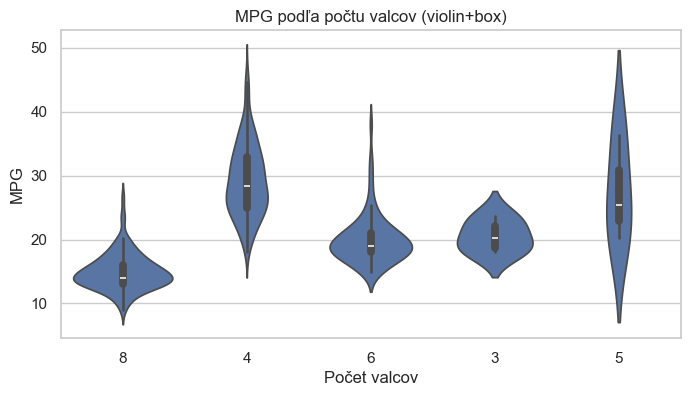

<Figure size 400x400 with 0 Axes>

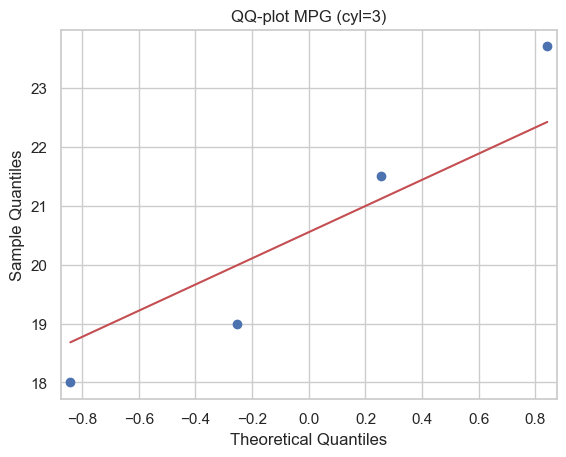

<Figure size 400x400 with 0 Axes>

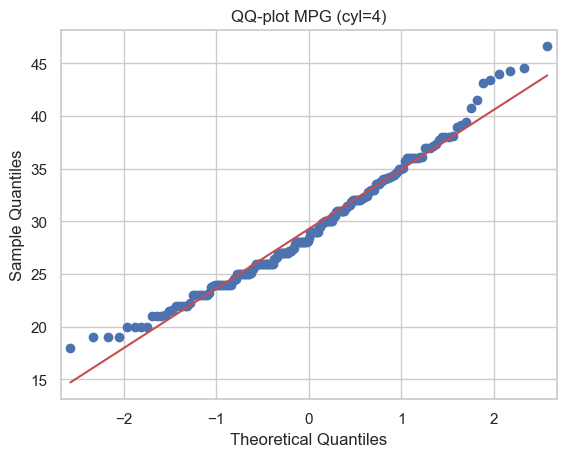

<Figure size 400x400 with 0 Axes>

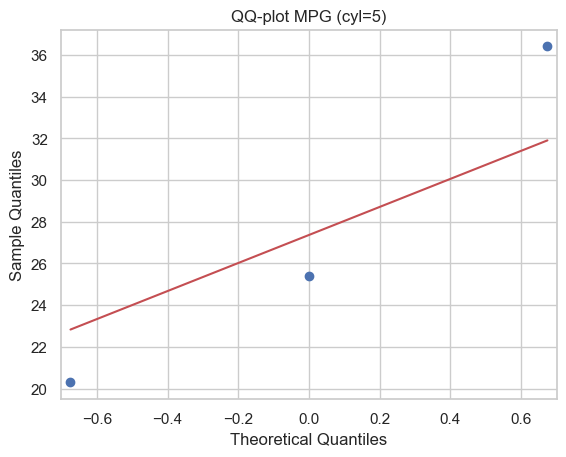

<Figure size 400x400 with 0 Axes>

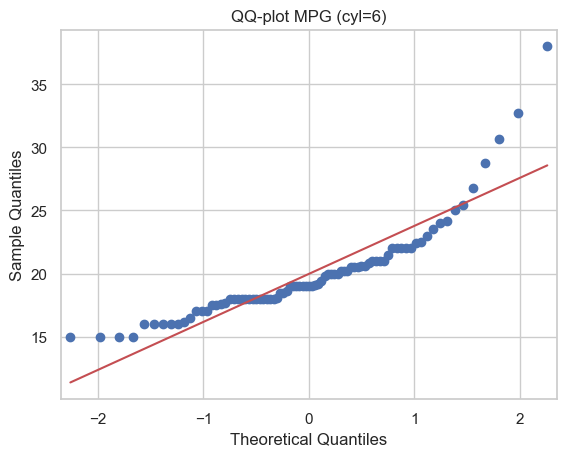

<Figure size 400x400 with 0 Axes>

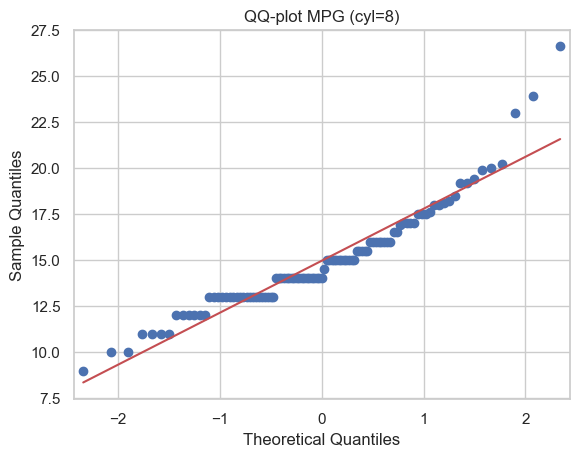

In [53]:
plt.figure(figsize=(8,4))
sns.violinplot(x=cars['cylinders'].astype(str), y='mpg', data=cars, inner='box')
plt.xlabel('Počet valcov'); plt.ylabel('MPG')
plt.title('MPG podľa počtu valcov (violin+box)')
plt.show()

# QQ-ploty pre mpg v skupinách (orientačne)
import statsmodels.api as sm
for c in sorted(cars['cylinders'].dropna().unique()):
    plt.figure(figsize=(4,4))
    sm.qqplot(cars.loc[cars['cylinders']==c, 'mpg'], line='s')
    plt.title(f'QQ-plot MPG (cyl={c})')
    plt.show()

### Report

1. ANOVA test ukázal, že existujú štatisticky významné rozdiely v spotrebe medzi skupinami motorov s rôznym počtom valcov (p < 0.05).
2. Post-hoc testy (Tukey HSD a Dunnov test s Holm-Bonferroni korekciou) identifikovali konkrétne páry skupín, ktoré sa líšia:
   - Medzi 4-valcovými a 6-valcovými motormi bol zistený štatisticky významný rozdiel v spotrebe (p < 0.05).
3. Veľkosť efektu medzi 4-valcovými a 6-valcovými motormi bola hodnotená pomocou Cohenovho d (d = ...) a Cliffovho delta (delta = ...), čo naznačuje (malý/stredný/veľký) efekt.

